In [1]:
import tensorflow as tf

import os
import sys
import numpy as np
from scipy.io import savemat
from sklearn.linear_model import SGDClassifier

# os.environ["CUDA_VISIBLE_DEVICES"] = "1"
sys.path.append(os.path.abspath('helper'))
# import utils
# import loader
import utils_GAN, PAD, utils_GAN_FiLM

2025-08-17 22:08:47.809360: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755482927.823658  115832 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755482927.827984  115832 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755482927.839031  115832 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1755482927.839043  115832 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1755482927.839044  115832 computation_placer.cc:177] computation placer alr

In [2]:
notebook_dir = os.getcwd()
print(notebook_dir)
print(os.path.abspath(os.path.join(notebook_dir, '..', '..')))
sys.path.append(os.path.abspath(os.path.join(notebook_dir, '..', '..')))
import Est_btween_CSIRS.helper.utils as utils_CNN
import Est_btween_CSIRS.helper.loader as loader
import Est_btween_CSIRS.helper.plotfig as plotfig

/home/thien/Code/H_predict_UDA/H_predict_Sionna/Domain_Adaptation/Domain_Adversarial
/home/thien/Code/H_predict_UDA/H_predict_Sionna


In [3]:
# Generate a (16, 792, 14, 2) matrix with random values
random_matrix = np.random.randn(16, 312, 14, 2)
random_matrix.shape

GAN_model = utils_GAN.GAN(n_subc=312)
out_put = GAN_model(random_matrix)
print(out_put.gen_out.shape)
print(out_put.disc_out.shape)
print(out_put.extracted_features.shape)

I0000 00:00:1755188346.945914  110914 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9548 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5
I0000 00:00:1755188346.946449  110914 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9548 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:67:00.0, compute capability: 7.5
I0000 00:00:1755188346.946951  110914 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 9484 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:68:00.0, compute capability: 7.5
I0000 00:00:1755188349.352506  110914 cuda_dnn.cc:529] Loaded cuDNN version 90300


(16, 312, 14, 2)
(16, 8, 4, 1)
(16, 18, 14, 512)


In [4]:
source_data_file_path = os.path.abspath(os.path.join(notebook_dir, '..', '..', 'Generate_Data', 'CDL_Channel', 'generatedChannel', 'ver9_', '0dB', 'mapBaseData.mat'))
target_data_file_path = os.path.abspath(os.path.join(notebook_dir, '..', '..', 'Generate_Data', 'Sionna', 'generatedChannel', 'ver3_', 'sionnaTrue.mat'))

In [5]:
norm_approach = 'minmax' # can be set to 'std'
lower_range = -1 
    # if norm_approach = 'minmax': 
        # =  0 for scaling to  [0 1]
        # = -1 for scaling to [-1 1]
    # if norm_approach = 'std': can be any value, but need to be defined
adv_weight=0.005
est_weight=1
domain_weight=0 # 0.5 for Domain Discriminator, 0 for no Domain Discriminator

# snr_start = -25
# snr_step = 5
# snr_end = 25
# SNR = np.arange(snr_start, snr_end+1, snr_step)

# SNR = np.array([0])

# if len(SNR) >1:
#     SNR_txt = f'{snr_start}:{snr_step}:{snr_end}'
# else:
#     SNR_txt = f'{SNR[0]}'
    
# ============ CNN settings ==============
if norm_approach == 'minmax':
    if lower_range == 0:
        norm_txt = 'Using min-max [0 1]'
    elif lower_range ==-1:
        norm_txt = 'Using min-max [-1 1]'
elif norm_approach == 'no':
    norm_txt = 'No'
    
CNN_activation = 'Tanh'
CNN_DropOut = 0.2
if CNN_DropOut != 0:
    dropOut_txt = f'Add p={CNN_DropOut} DropOut'
    
# ============ Adversarial for Domain Discriminator settings ==============
    
    
# # create readme.txt file
# content = f"""Generated by file 'Domain_Adversarial/UDA_CNN_v3.ipynb'.
# 28 GHz fc,
# Source dataset got from {source_data_file_path},
# Target dataset got from {target_data_file_path},
# Learning rate {learning_rate},
# {norm_txt} scaler for each sample
# Using {CNN_activation} as activation function of CNN
# {dropOut_txt}
# ========= For Domain Discriminator ==========
# Extract features after layer {extract_layer} of CNN
# {text_lambda}
# """

In [6]:
# Paths to save
idx_save_path = loader.find_incremental_filename(notebook_dir + '/model/GAN','ver', '_', '')

save_model = 0
model_path = notebook_dir + '/model/GAN/ver' + str(idx_save_path) + '_'
# figure_path = notebook_dir + '/model/GAN/ver' + str(idx_save_path) + '_/figure'
model_readme = model_path + '/readme.txt'
# figure_readme = figure_path + '/readme.txt'

# if not os.path.exists(os.path.dirname(model_readme)):
#     os.makedirs(os.path.dirname(model_readme))
# # if not os.path.exists(os.path.dirname(figure_readme)):
# #     os.makedirs(os.path.dirname(figure_readme))

# # Open the file in write mode ('w'). If the file does not exist, it will be created.
# with open(model_readme, 'w') as file:
#     # Write the content to the file
#     file.write(content)

# # with open(figure_readme, 'w') as file:
# #     # Write the content to the file
# #     file.write(content)

# print(f"File '{model_readme}'  created and content written.")


In [7]:
import h5py

batch_size=16

# ============ Source data ==============
source_file = h5py.File(source_data_file_path, 'r')
H_true_source = source_file['H_true']
N_samp_source = H_true_source.shape[0]
print('N_samp_source = ', N_samp_source)

# ============ Target data ==============
target_file = h5py.File(target_data_file_path, 'r')
H_true_target = target_file['H_true']
N_samp_target = H_true_target.shape[0]
print('N_samp_target = ', N_samp_target)

N_samp_source =  2048
N_samp_target =  2048


In [8]:
indices_source = np.arange(N_samp_source)
np.random.shuffle(indices_source)
indices_target = np.arange(N_samp_target)
np.random.shuffle(indices_target)
#
train_size = int(np.floor(N_samp_source * 0.9) // batch_size * batch_size)
val_size = N_samp_source - train_size

# Repeat the indices to match the maximum number of samples
N_samp = max(N_samp_source, N_samp_target) 
indices_source = np.resize(indices_source, N_samp)
indices_target = np.resize(indices_target, N_samp)

# =======================================================
## Divide the indices into training and validation sets
indices_train_source = indices_source[:train_size]
indices_val_source   = indices_source[train_size:train_size + val_size]

indices_train_target = indices_target[:train_size]
indices_val_target   = indices_target[train_size:train_size + val_size]

# to test code
# indices_train_source = indices_source[:96]
# indices_val_source = indices_source[2032:]
# indices_train_target = indices_target[:96]
# indices_val_target = indices_target[2032:]

print('train_size = ', indices_train_source.shape[0])
print('val_size = ', indices_val_source.shape[0])

train_size =  1840
val_size =  208


In [9]:
# =========== Source dataset ==============
loader_H_true_train_source = utils_CNN.H5BatchLoader(source_file, dataset_name='H_true', batch_size=batch_size, shuffled_indices=indices_train_source)
loader_H_practical_train_source = utils_CNN.H5BatchLoader(source_file, 'H_practical_save', batch_size=batch_size, shuffled_indices=indices_train_source)
loader_H_linear_train_source = utils_CNN.H5BatchLoader(source_file, 'H_linear_save', batch_size=batch_size, shuffled_indices=indices_train_source)

loader_H_true_val_source = utils_CNN.H5BatchLoader(source_file, dataset_name='H_true', batch_size=batch_size, shuffled_indices=indices_val_source)
loader_H_practical_val_source = utils_CNN.H5BatchLoader(source_file, 'H_practical_save', batch_size=batch_size, shuffled_indices=indices_val_source)
loader_H_linear_val_source = utils_CNN.H5BatchLoader(source_file, 'H_linear_save', batch_size=batch_size, shuffled_indices=indices_val_source)


# =========== Target dataset ==============
# replace source_file by target_file
loader_H_true_train_target = utils_CNN.H5BatchLoader(source_file, dataset_name='H_true', batch_size=batch_size, shuffled_indices=indices_train_target)
    # actually at target domain, we don't have true channels, just use this for evaluating the model
loader_H_practical_train_target = utils_CNN.H5BatchLoader(source_file, 'H_practical_save', batch_size=batch_size, shuffled_indices=indices_train_target)
    # channel at symbol 2 of slots 1,6,11 (channel corresponding to CSI-RS 1, 2)
loader_H_true_val_target = utils_CNN.H5BatchLoader(source_file, dataset_name='H_true', batch_size=batch_size, shuffled_indices=indices_val_target)
loader_H_practical_val_target = utils_CNN.H5BatchLoader(source_file, 'H_practical_save', batch_size=batch_size, shuffled_indices=indices_val_target)

print('size loader_H_true_train = ', loader_H_true_train_target.total_batches)
print('size loader_H_true_val = ', loader_H_true_val_target.total_batches)

size loader_H_true_train =  115
size loader_H_true_val =  13


In [10]:
class DataLoaders:
    def __init__(self, file, indices_train, indices_val, tag='practical', batch_size=32):
        self.true_train = utils_CNN.H5BatchLoader(file, dataset_name='H_true', batch_size=batch_size, shuffled_indices=indices_train)
        self.true_val = utils_CNN.H5BatchLoader(file, dataset_name='H_true', batch_size=batch_size, shuffled_indices=indices_val)

        self.input_train = utils_CNN.H5BatchLoader(file, f'H_{tag}_save', batch_size=batch_size, shuffled_indices=indices_train)
        self.input_val = utils_CNN.H5BatchLoader(file, f'H_{tag}_save', batch_size=batch_size, shuffled_indices=indices_val)

# Source domain
class_dict_source = {
    'GAN_practical': DataLoaders(source_file, indices_train_source, indices_val_source, tag='practical', batch_size=batch_size),
    'GAN_linear': DataLoaders(source_file, indices_train_source, indices_val_source, tag='linear', batch_size=batch_size)
}

# Target domain
# replace source_file by target_file when run UDA
class_dict_target = {
    'GAN_practical': DataLoaders(source_file, indices_train_target, indices_val_target, tag='practical', batch_size=batch_size),
    'GAN_linear': DataLoaders(source_file, indices_train_target, indices_val_target, tag='linear', batch_size=batch_size)
}

In [11]:
# Calculate PAD for original datasets with SVM
# pad = PAD.original_PAD(loader_H_practical_train_source, loader_H_practical_train_target)
# print(f"PAD = {pad:.4f}")

In [12]:
loss_fn_ce = tf.keras.losses.MeanSquaredError()  # Channel estimation loss (generator loss)
loss_fn_bce = tf.keras.losses.BinaryCrossentropy(from_logits=False) # Binary cross-entropy loss for discriminator
loss_fn_domain = tf.keras.losses.BinaryCrossentropy()  # Domain classification loss

In [13]:
import time
start = time.perf_counter()

n_epochs= 600
epoch_min = 120
epoch_step = 200
# n_epochs= 3
# epoch_min = 0
# epoch_step = 1

sub_folder_ = ['GAN_linear', 'GAN_practical']

for sub_folder in sub_folder_:
    print(f"Processing: {sub_folder}")
    linear_interp = False
    if sub_folder == 'GAN_linear':
        linear_interp =True # flag to clip values that go beyond the estimated pilot (min, max)
    ##
    loader_H_true_train_source = class_dict_source[sub_folder].true_train
    loader_H_input_train_source = class_dict_source[sub_folder].input_train
    loader_H_true_val_source = class_dict_source[sub_folder].true_val
    loader_H_input_val_source = class_dict_source[sub_folder].input_val
    
    loader_H_true_train_target = class_dict_target[sub_folder].true_train
    loader_H_input_train_target = class_dict_target[sub_folder].input_train
    loader_H_true_val_target = class_dict_target[sub_folder].true_val
    loader_H_input_val_target = class_dict_target[sub_folder].input_val
    ##
    
    if not os.path.exists(os.path.dirname(model_path + '/' + sub_folder +'/')):
        os.makedirs(os.path.dirname(model_path + '/' + sub_folder + '/'))   # Domain_Adversarial/model/_/ver_/{sub_folder}

    train_loss          = [] # (epoch,1)
    train_est_loss      = [] 
    train_disc_loss     = [] 
    train_domain_loss   = []
    train_est_loss_target = []
    #    
    val_loss, val_gan_disc_loss, val_domain_disc_loss,\
    val_est_loss_source, val_est_loss_target, val_est_loss,\
    source_acc, target_acc, acc,\
    nmse_val_source, nmse_val_target, nmse_val = [[] for _ in range(12)]
    #
    H_to_save = {}          # list to save to .mat file for H
    perform_to_save = {}    # list to save to .mat file for nmse, losses,...

    model = utils_GAN.GAN(n_subc=312, gen_l2=None, disc_l2=1e-5)  # l2 regularization for generator and discriminator
    model_domain = utils_GAN_FiLM.DomainDiscriminator3()
    gen_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5, beta_2=0.9)
    disc_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5, beta_1=0.5, beta_2=0.9)  # WGAN-GP uses Adam optimizer with beta_1=0.5
    domain_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    ####
    optimizer = [gen_optimizer, disc_optimizer, domain_optimizer]
    ####
    
    flag = 1 # flag to plot and save H_true
    pad_observe = [] # pad observation over epochs
    epoc_pad = []    # epochs that calculating pad (return_features == True)
    for epoch in range(n_epochs):
        # ===================== Training =====================
        loader_H_true_train_source.reset()
        # loader_H_practical_train_source.reset()
        loader_H_input_train_source.reset()
        loader_H_true_train_target.reset()
        # loader_H_practical_train_target.reset()
        loader_H_input_train_target.reset()
                
        # loader_H = [loader_H_practical_train_source, loader_H_true_train_source, loader_H_practical_train_target, loader_H_true_train_target]
        loader_H = [loader_H_input_train_source, loader_H_true_train_source, loader_H_input_train_target, loader_H_true_train_target]
        
        loss_fn = [loss_fn_ce, loss_fn_bce, loss_fn_domain]
    
        ##########################
        if epoch in [int(n_epochs * r) for r in [0.25, 0.5, 0.75, 1.0]]:
            # return_features == return features to calculate PAD
            return_features = True
            epoc_pad.append(epoch)
        else:
            return_features = False

        ##########################
        train_step_output = utils_GAN.train_step_wgan_gp(model, model_domain, loader_H, loss_fn, optimizer, lower_range=-1,
                                adv_weight=adv_weight, est_weight=est_weight, domain_weight=domain_weight, return_features=return_features, linear_interp=linear_interp)
        
        train_epoc_loss_est        = train_step_output.avg_epoc_loss_est
        train_epoc_loss_d          = train_step_output.avg_epoc_loss_d
        train_epoc_loss_domain     = train_step_output.avg_epoc_loss_domain
        train_epoc_loss            = train_step_output.avg_epoc_loss
        train_epoc_loss_est_target = train_step_output.avg_epoc_loss_est_target
                # train_epoc_loss        = total train loss = loss_est + lambda_domain * domain_loss
                # train_epoc_loss_est    = loss in estimation network in source domain (labels available)
                # train_epoc_loss_domain = loss in domain discrimination network
                # train_epoc_loss_est_target - just to monitor - the machine can not calculate because no label available in source domain
                # All are already calculated in average over training dataset (source/target - respectively)
        print("Time", time.perf_counter() - start, "seconds")
        # Calculate PAD for the extracted features
        if return_features and (domain_weight!=0):
            features_source_file = "features_source.h5"
            features_target_file = "features_target.h5"
            print(f"epoch {epoch+1}/{n_epochs}")
            # pad_epoc_sgd  = PAD.cal_PAD_SGD(features_source_file, features_target_file)
            pad_epoc  = PAD.cal_PAD2(features_source_file, features_target_file, pca_components=100, batch_size=128)
            pad_observe.append(pad_epoc)
            if os.path.exists(features_source_file):
                os.remove(features_source_file)
            if os.path.exists(features_target_file):
                os.remove(features_target_file)
            print("Time", time.perf_counter() - start, "seconds")
            
        
        # Average loss for the epoch
        train_loss.append(train_epoc_loss)
        print(f"epoch {epoch+1}/{n_epochs} Average Training Loss: {train_epoc_loss:.6f}")
        #
        train_est_loss.append(train_epoc_loss_est)
        print(f"epoch {epoch+1}/{n_epochs} Average Estimation Loss (in Source domain): {train_epoc_loss_est:.6f}")
        #
        train_disc_loss.append(train_epoc_loss_d)
        print(f"epoch {epoch+1}/{n_epochs} Average Disc Loss (in Source domain): {train_epoc_loss_d:.6f}")
        #
        train_domain_loss.append(train_epoc_loss_domain)
        print(f"epoch {epoch+1}/{n_epochs} Average Domain Discrimination Loss: {train_epoc_loss_domain:.6f}")
        #
        train_est_loss_target.append(train_epoc_loss_est_target)
        print(f"epoch {epoch+1}/{n_epochs} For observation only - Average Estimation Loss in Target domain: {train_epoc_loss_est_target:.6f}")
        
        
        # ===================== Evaluation =====================
        loader_H_true_val_source.reset()
        loader_H_input_val_source.reset()
        loader_H_true_val_target.reset()
        loader_H_input_val_target.reset()
        loader_H_eval = [loader_H_input_val_source, loader_H_true_val_source, loader_H_input_val_target, loader_H_true_val_target]

        loss_fn = [loss_fn_ce, loss_fn_bce, loss_fn_domain]
        
        # eval_func = utils_UDA_FiLM.val_step
        if (epoch+1>epoch_min and epoch%epoch_step==0) or epoch==n_epochs-1:
            H_sample, epoc_val_return = utils_GAN.val_step_wgan_gp(model, model_domain, loader_H_eval, loss_fn, lower_range, 
                                            adv_weight=adv_weight, est_weight=est_weight, domain_weight=domain_weight, linear_interp=linear_interp)
            utils_GAN.visualize_H(H_sample, H_to_save, epoch, plotfig.figChan, flag, model_path, sub_folder, domain_weight=domain_weight)
            flag = 0  # after the first epoch, no need to save H_true anymore
            
        else:
            _, epoc_val_return = utils_GAN.val_step_wgan_gp(model, model_domain, loader_H_eval, loss_fn, lower_range, 
                                            adv_weight=adv_weight, est_weight=est_weight, domain_weight=domain_weight, linear_interp=linear_interp)
        
        utils_GAN.post_val(epoc_val_return, epoch, n_epochs, val_est_loss, val_est_loss_source, val_loss, val_est_loss_target,
            val_gan_disc_loss, val_domain_disc_loss, nmse_val_source, nmse_val_target, nmse_val, source_acc, target_acc, acc, domain_weight=domain_weight)
        
        
        if (epoch+1>epoch_min and (epoch+1)%epoch_step==0) or epoch==n_epochs-1:
            utils_GAN.save_checkpoint(model, save_model, model_path, sub_folder, epoch, plotfig.figLoss, savemat, train_loss, train_est_loss, train_domain_loss, train_est_loss_target,
                    val_est_loss, val_est_loss_source, val_loss, val_est_loss_target, val_gan_disc_loss, val_domain_disc_loss,
                    source_acc, target_acc, acc, nmse_val_source, nmse_val_target, nmse_val, pad_observe, epoc_pad, train_disc_loss, domain_weight=domain_weight)
    
    # end of epoch loop
    # =====================            
    # Save performances
    # Save H matrix
    savemat(model_path + '/' + sub_folder + '/H_visualize/H_trix.mat', H_to_save)

# end of trainmode   
    

Processing: GAN_linear
Time 92.96085155685432 seconds
epoch 1/600 Average Training Loss: 0.029196
epoch 1/600 Average Estimation Loss (in Source domain): 0.028440
epoch 1/600 Average Disc Loss (in Source domain): 1706.404541
epoch 1/600 Average Domain Discrimination Loss: 0.000000
epoch 1/600 For observation only - Average Estimation Loss in Target domain: 0.028440
epoch 1/600 (Val) Weighted Total Loss: 1.493439
epoch 1/600 (Val) Average Estimation Loss (mean): 0.024243
epoch 1/600 (Val) Average Estimation Loss (Source): 0.025241
epoch 1/600 (Val) GAN Discriminator Loss: 293.839294
epoch 1/600 (Val) NMSE (Source): 0.024148, NMSE (Target): 0.022057, NMSE (Mean): 0.023103
epoch 1/600 (Val) Domain Discriminator Accuracy (Average): 0.5024
Time 187.34795996383764 seconds
epoch 2/600 Average Training Loss: 0.012092
epoch 2/600 Average Estimation Loss (in Source domain): 0.011325
epoch 2/600 Average Disc Loss (in Source domain): 35.649166
epoch 2/600 Average Domain Discrimination Loss: 0.0000

/home/thien/Code/H_predict_UDA/H_predict_Sionna/Est_btween_CSIRS/helper/plotfig.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 5))


Time 72455.35863402393 seconds
epoch 201/600 Average Training Loss: 0.000873
epoch 201/600 Average Estimation Loss (in Source domain): 0.000749
epoch 201/600 Average Disc Loss (in Source domain): 0.002837
epoch 201/600 Average Domain Discrimination Loss: 0.000000
epoch 201/600 For observation only - Average Estimation Loss in Target domain: 0.000749
epoch 201/600 (Val) Weighted Total Loss: 0.004906
epoch 201/600 (Val) Average Estimation Loss (mean): 0.004852
epoch 201/600 (Val) Average Estimation Loss (Source): 0.006949
epoch 201/600 (Val) GAN Discriminator Loss: 0.010684
epoch 201/600 (Val) NMSE (Source): 0.003914, NMSE (Target): 0.001588, NMSE (Mean): 0.002751
epoch 201/600 (Val) Domain Discriminator Accuracy (Average): 0.5312
Time 72533.70860211994 seconds
epoch 202/600 Average Training Loss: 0.000843
epoch 202/600 Average Estimation Loss (in Source domain): 0.000739
epoch 202/600 Average Disc Loss (in Source domain): 0.002691
epoch 202/600 Average Domain Discrimination Loss: 0.0000

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

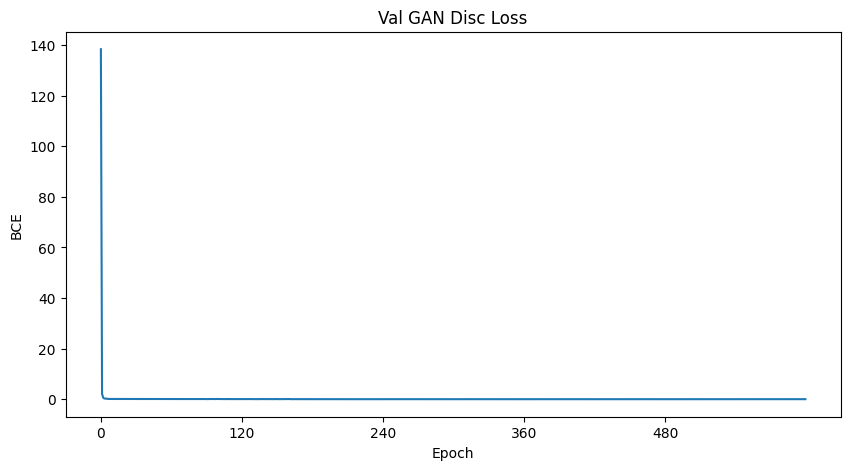

<Figure size 640x480 with 0 Axes>

In [14]:
plotfig.figLoss(line_list=[(val_gan_disc_loss, 'Val Disc Loss')], xlabel='Epoch', ylabel='BCE',
                        title='Val GAN Disc Loss', fig_show=True, fig_name='Loss')

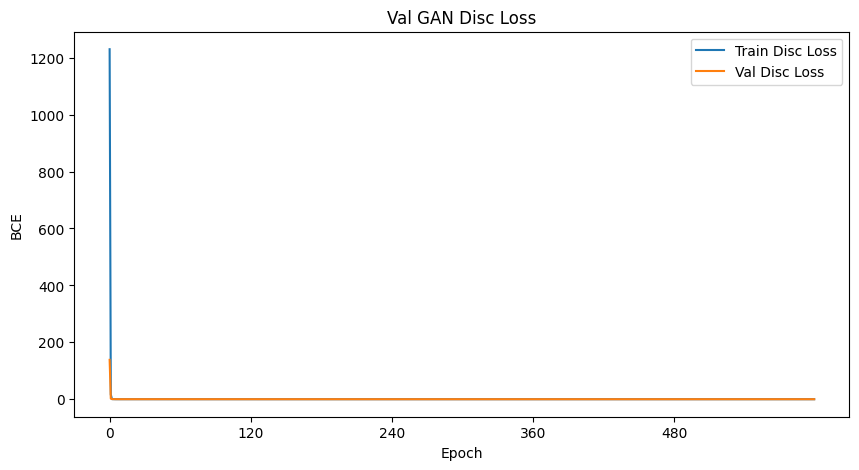

<Figure size 640x480 with 0 Axes>

In [15]:
plotfig.figLoss(line_list=[(train_disc_loss, 'Train Disc Loss'), (val_gan_disc_loss, 'Val Disc Loss')], xlabel='Epoch', ylabel='BCE',
                        title='Val GAN Disc Loss', fig_show=True, fig_name='Loss')

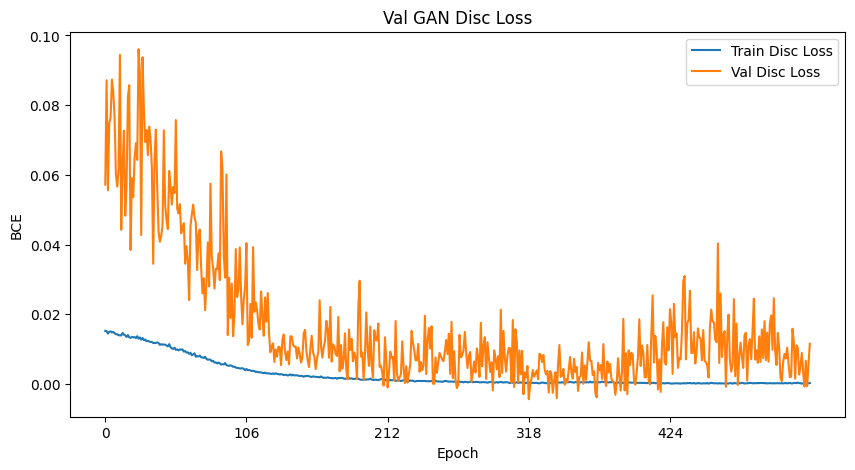

<Figure size 640x480 with 0 Axes>

In [16]:
plotfig.figLoss(line_list=[(train_disc_loss[70:], 'Train Disc Loss'), (val_gan_disc_loss[70:], 'Val Disc Loss')], xlabel='Epoch', ylabel='BCE',
                        title='Val GAN Disc Loss', fig_show=True, fig_name='Loss')

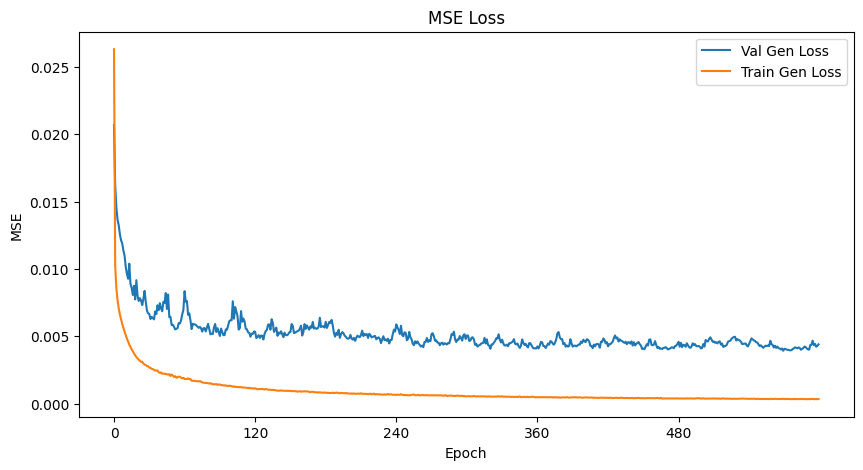

<Figure size 640x480 with 0 Axes>

In [17]:
plotfig.figLoss(line_list=[(val_est_loss, 'Val Gen Loss'), (train_est_loss, 'Train Gen Loss')], xlabel='Epoch', ylabel='MSE',
                        title='MSE Loss', fig_show=True, fig_name='Loss')
            

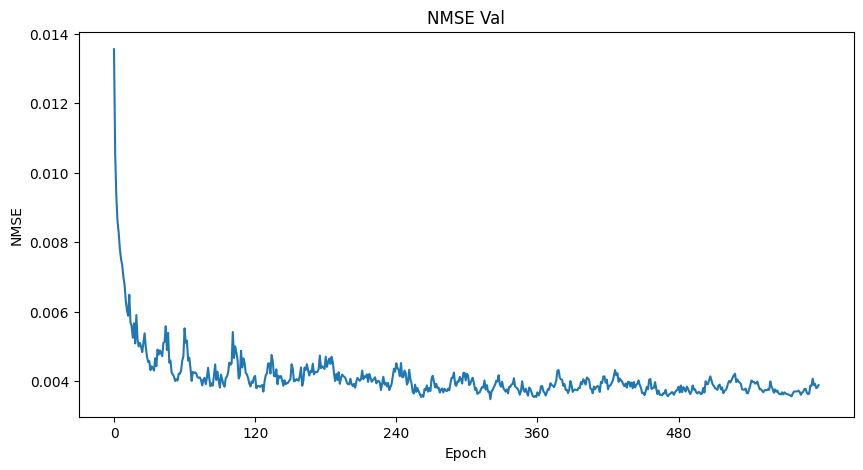

<Figure size 640x480 with 0 Axes>

In [18]:
plotfig.figLoss(line_list=[(nmse_val_source, 'Val NMSE')], xlabel='Epoch', ylabel='NMSE',
                        title='NMSE Val', fig_show=True, fig_name='Loss')

In [5]:
import scipy.io

# Load the .mat file
data28_practical = scipy.io.loadmat('model/GAN/ver28_/GAN_practical/performance/performance.mat')
data27_practical = scipy.io.loadmat('model/GAN/ver27_/GAN_practical/performance/performance.mat')
data29_practical = scipy.io.loadmat('model/GAN/ver29_/GAN_practical/performance/performance.mat')

data28_linear = scipy.io.loadmat('model/GAN/ver28_/GAN_linear/performance/performance.mat')
data27_linear = scipy.io.loadmat('model/GAN/ver27_/GAN_linear/performance/performance.mat')
data29_linear = scipy.io.loadmat('model/GAN/ver29_/GAN_linear/performance/performance.mat')

# Practical

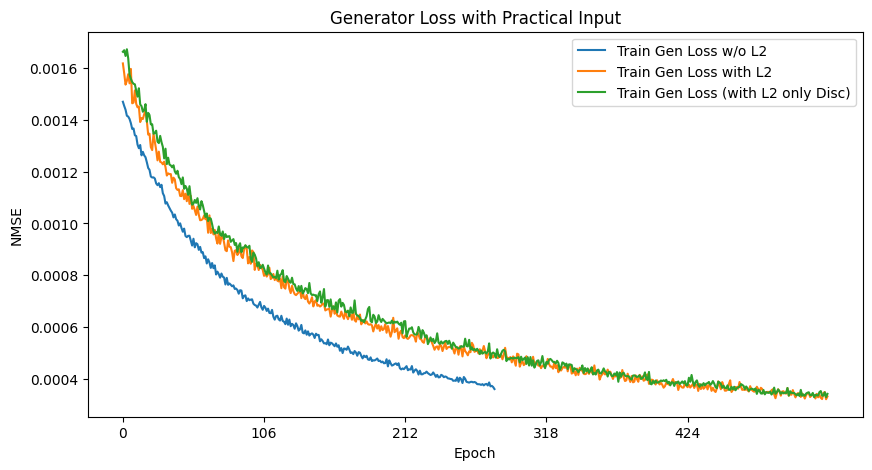

<Figure size 640x480 with 0 Axes>

In [28]:
toplot_1 = data27_practical['train_est_loss'].flatten().tolist()
toplot_2 = data28_practical['train_est_loss'].flatten().tolist()
toplot_3 = data29_practical['train_est_loss'].flatten().tolist()
plotfig.figLoss(line_list=[(toplot_1[70:], 'Train Gen Loss w/o L2'), (toplot_2[70:], 'Train Gen Loss with L2'),
                        (toplot_3[70:], 'Train Gen Loss (with L2 only Disc)')], xlabel='Epoch', ylabel='NMSE',
                        title='Generator Loss with Practical Input', fig_show=True, fig_name='Loss')

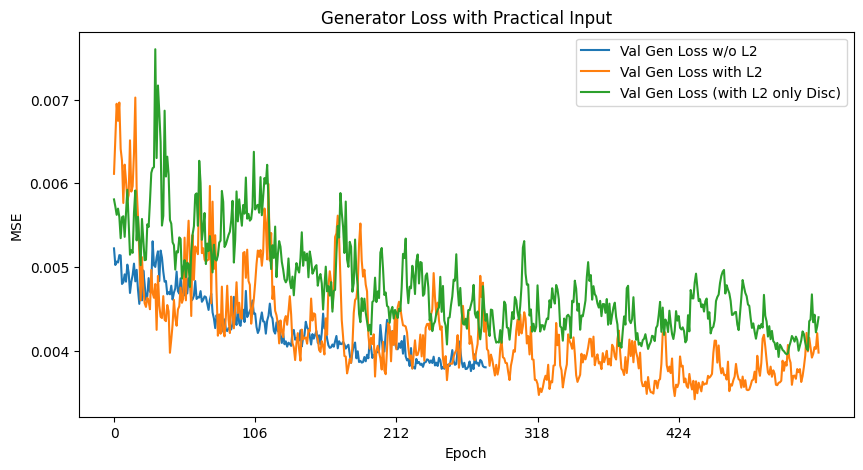

<Figure size 640x480 with 0 Axes>

In [ ]:
toplot_1 = data27_practical['val_est_loss'].flatten().tolist()
toplot_2 = data28_practical['val_est_loss'].flatten().tolist()
toplot_3 = data29_practical['val_est_loss'].flatten().tolist()
plotfig.figLoss(line_list=[(toplot_1[70:], 'Val Gen Loss w/o L2'), (toplot_2[70:], 'Val Gen Loss with L2'),
                        (toplot_3[70:], 'Val Gen Loss (with L2 only Disc)')], xlabel='Epoch', ylabel='MSE',
                        title='Generator Loss with Practical Input', fig_show=True, fig_name='Loss')

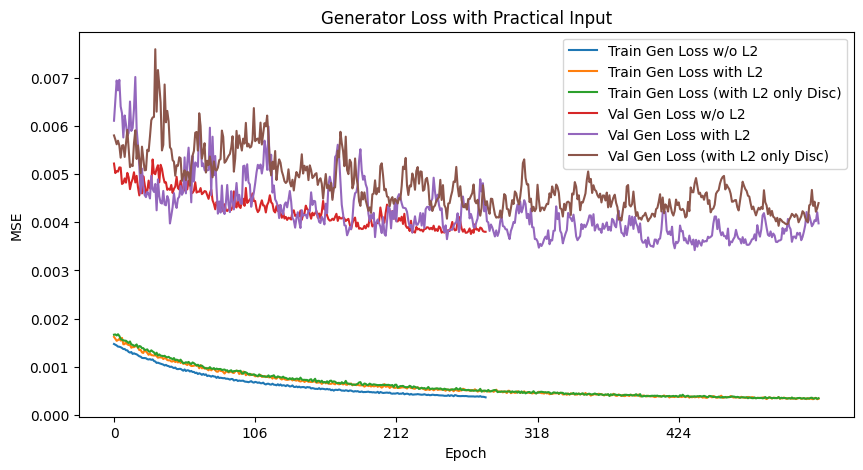

<Figure size 640x480 with 0 Axes>

In [17]:
toplot_1 = data27_practical['train_est_loss'].flatten().tolist()
toplot_2 = data28_practical['train_est_loss'].flatten().tolist()
toplot_3 = data29_practical['train_est_loss'].flatten().tolist()
toplot_1_ = data27_practical['val_est_loss'].flatten().tolist()
toplot_2_ = data28_practical['val_est_loss'].flatten().tolist()
toplot_3_ = data29_practical['val_est_loss'].flatten().tolist()
plotfig.figLoss(line_list=[(toplot_1[70:], 'Train Gen Loss w/o L2'), (toplot_2[70:], 'Train Gen Loss with L2'),
                        (toplot_3[70:], 'Train Gen Loss (with L2 only Disc)'), (toplot_1_[70:], 'Val Gen Loss w/o L2'), (toplot_2_[70:], 'Val Gen Loss with L2'),
                        (toplot_3_[70:], 'Val Gen Loss (with L2 only Disc)')], xlabel='Epoch', ylabel='MSE',
                        title='Generator Loss with Practical Input', fig_show=True, fig_name='Loss')

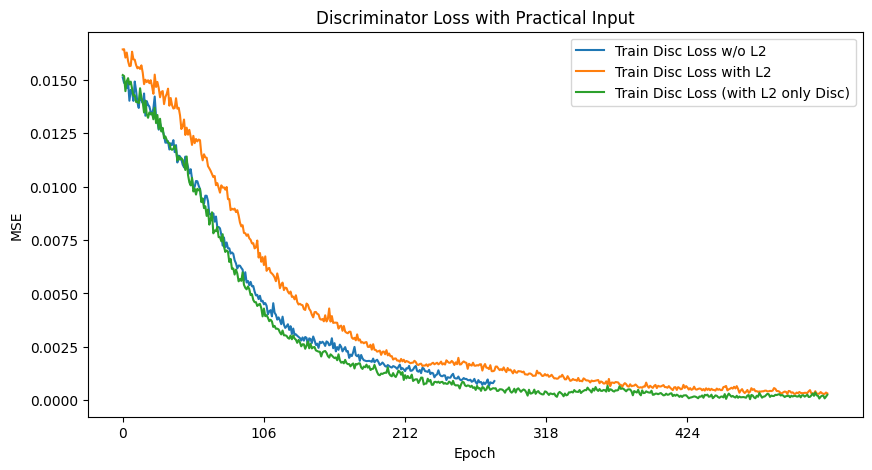

<Figure size 640x480 with 0 Axes>

In [18]:
toplot_1 = data27_practical['train_disc_loss'].flatten().tolist()
toplot_2 = data28_practical['train_disc_loss'].flatten().tolist()
toplot_3 = data29_practical['train_disc_loss'].flatten().tolist()
plotfig.figLoss(line_list=[(toplot_1[70:], 'Train Disc Loss w/o L2'), (toplot_2[70:], 'Train Disc Loss with L2'),
                        (toplot_3[70:], 'Train Disc Loss (with L2 only Disc)')], xlabel='Epoch', ylabel='MSE',
                        title='Discriminator Loss with Practical Input', fig_show=True, fig_name='Loss')

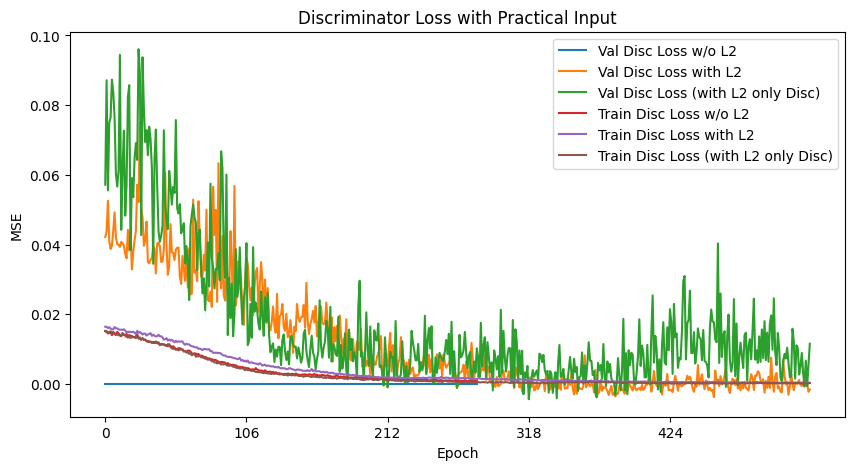

<Figure size 640x480 with 0 Axes>

In [14]:
toplot_1 = data27_practical['val_gan_disc_loss'].flatten().tolist()
toplot_2 = data28_practical['val_gan_disc_loss'].flatten().tolist()
toplot_3 = data29_practical['val_gan_disc_loss'].flatten().tolist()
toplot_1_ = data27_practical['train_disc_loss'].flatten().tolist()
toplot_2_ = data28_practical['train_disc_loss'].flatten().tolist()
toplot_3_ = data29_practical['train_disc_loss'].flatten().tolist()
plotfig.figLoss(line_list=[(toplot_1[70:], 'Val Disc Loss w/o L2'), (toplot_2[70:], 'Val Disc Loss with L2'),
                        (toplot_3[70:], 'Val Disc Loss (with L2 only Disc)'), (toplot_1_[70:], 'Train Disc Loss w/o L2'), (toplot_2_[70:], 'Train Disc Loss with L2'),
                        (toplot_3_[70:], 'Train Disc Loss (with L2 only Disc)')], xlabel='Epoch', ylabel='MSE',
                        title='Discriminator Loss with Practical Input', fig_show=True, fig_name='Loss')

In [19]:
print(data28_linear.keys())

dict_keys(['__header__', '__version__', '__globals__', 'train_loss', 'train_est_loss', 'train_disc_loss', 'train_domain_loss', 'train_est_loss_target', 'val_est_loss', 'val_est_loss_source', 'val_loss', 'val_est_loss_target', 'val_gan_disc_loss', 'val_domain_disc_loss', 'source_acc', 'target_acc', 'acc', 'nmse_val_source', 'nmse_val_target', 'nmse_val', 'pad_observe', 'epoc_pad'])


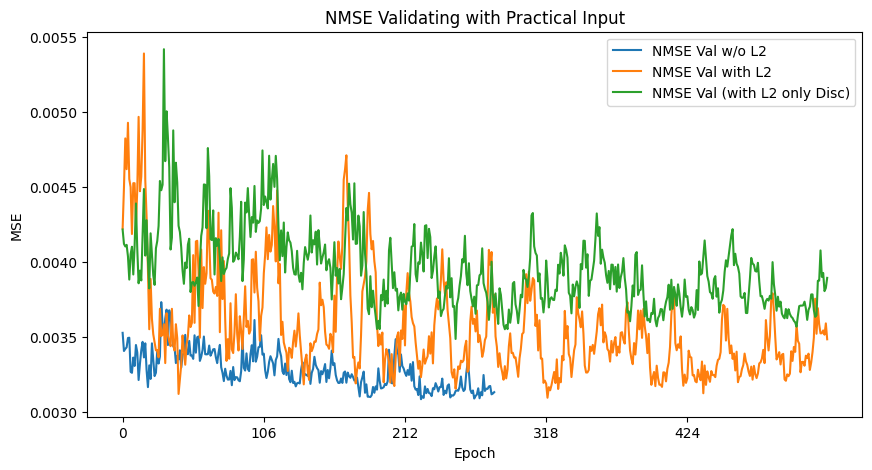

<Figure size 640x480 with 0 Axes>

In [20]:
toplot_1 = data27_practical['nmse_val_source'].flatten().tolist()
toplot_2 = data28_practical['nmse_val_source'].flatten().tolist()
toplot_3 = data29_practical['nmse_val_source'].flatten().tolist()
plotfig.figLoss(line_list=[(toplot_1[70:], 'NMSE Val w/o L2'), (toplot_2[70:], 'NMSE Val with L2'),
                        (toplot_3[70:], 'NMSE Val (with L2 only Disc)')], xlabel='Epoch', ylabel='MSE',
                        title='NMSE Validating with Practical Input', fig_show=True, fig_name='Loss')

# LI

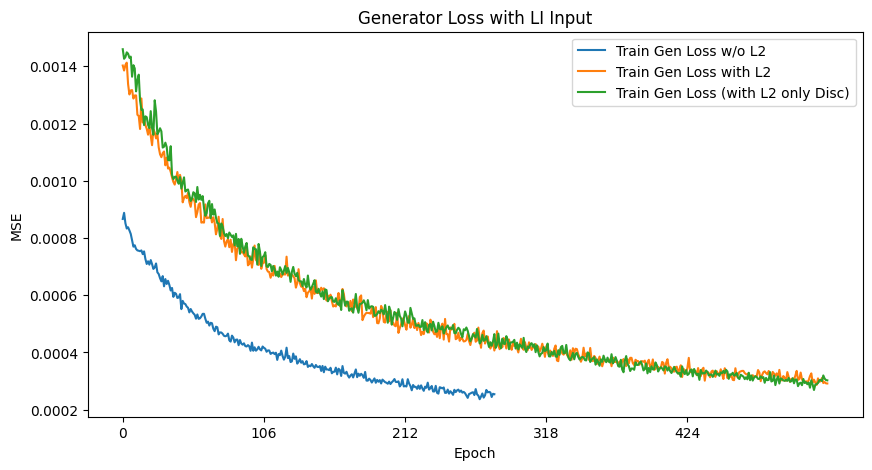

<Figure size 640x480 with 0 Axes>

In [21]:
toplot_1 = data27_linear['train_est_loss'].flatten().tolist()
toplot_2 = data28_linear['train_est_loss'].flatten().tolist()
toplot_3 = data29_linear['train_est_loss'].flatten().tolist()
plotfig.figLoss(line_list=[(toplot_1[70:], 'Train Gen Loss w/o L2'), (toplot_2[70:], 'Train Gen Loss with L2'),
                        (toplot_3[70:], 'Train Gen Loss (with L2 only Disc)')], xlabel='Epoch', ylabel='MSE',
                        title='Generator Loss with LI Input', fig_show=True, fig_name='Loss')

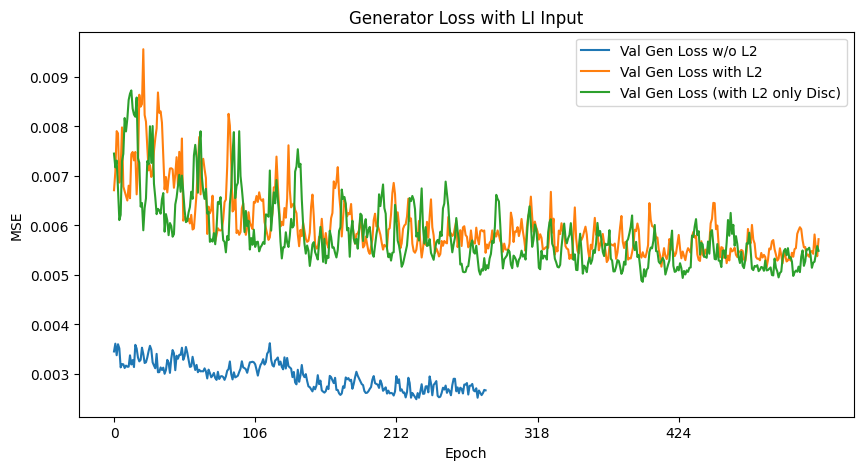

<Figure size 640x480 with 0 Axes>

In [22]:
toplot_1 = data27_linear['val_est_loss'].flatten().tolist()
toplot_2 = data28_linear['val_est_loss'].flatten().tolist()
toplot_3 = data29_linear['val_est_loss'].flatten().tolist()
plotfig.figLoss(line_list=[(toplot_1[70:], 'Val Gen Loss w/o L2'), (toplot_2[70:], 'Val Gen Loss with L2'),
                        (toplot_3[70:], 'Val Gen Loss (with L2 only Disc)')], xlabel='Epoch', ylabel='MSE',
                        title='Generator Loss with LI Input', fig_show=True, fig_name='Loss')

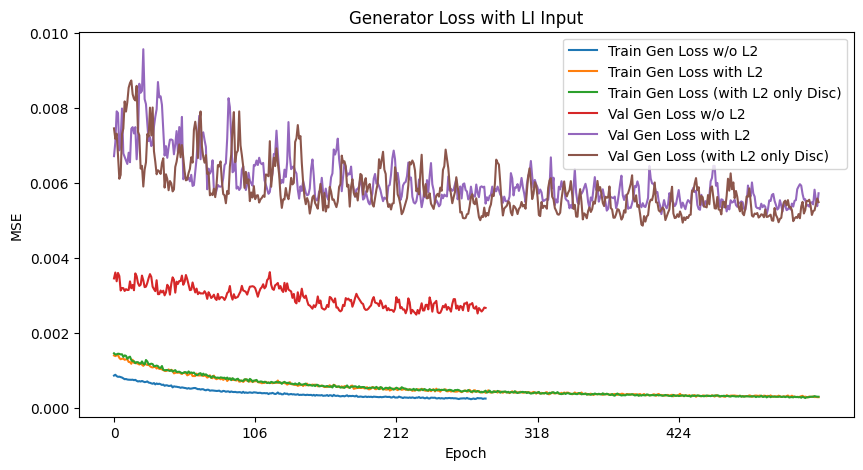

<Figure size 640x480 with 0 Axes>

In [23]:
toplot_1 = data27_linear['train_est_loss'].flatten().tolist()
toplot_2 = data28_linear['train_est_loss'].flatten().tolist()
toplot_3 = data29_linear['train_est_loss'].flatten().tolist()
toplot_1_ = data27_linear['val_est_loss'].flatten().tolist()
toplot_2_ = data28_linear['val_est_loss'].flatten().tolist()
toplot_3_ = data29_linear['val_est_loss'].flatten().tolist()
plotfig.figLoss(line_list=[(toplot_1[70:], 'Train Gen Loss w/o L2'), (toplot_2[70:], 'Train Gen Loss with L2'),
                        (toplot_3[70:], 'Train Gen Loss (with L2 only Disc)'), (toplot_1_[70:], 'Val Gen Loss w/o L2'), (toplot_2_[70:], 'Val Gen Loss with L2'),
                        (toplot_3_[70:], 'Val Gen Loss (with L2 only Disc)')], xlabel='Epoch', ylabel='MSE',
                        title='Generator Loss with LI Input', fig_show=True, fig_name='Loss')

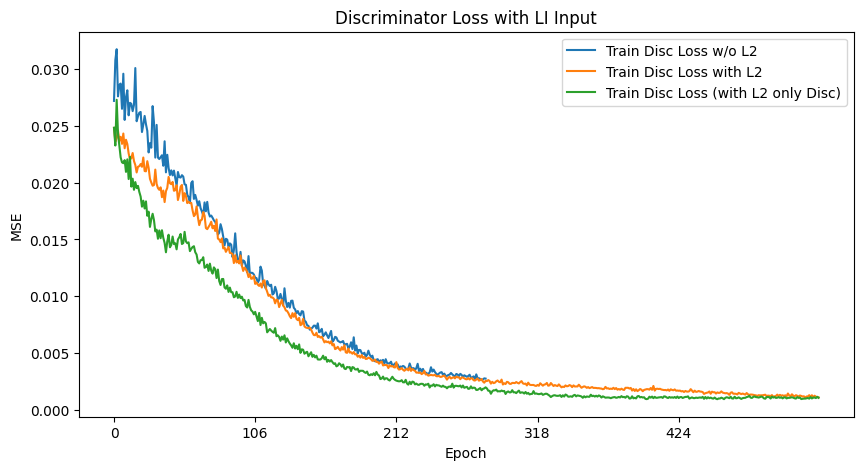

<Figure size 640x480 with 0 Axes>

In [24]:
toplot_1 = data27_linear['train_disc_loss'].flatten().tolist()
toplot_2 = data28_linear['train_disc_loss'].flatten().tolist()
toplot_3 = data29_linear['train_disc_loss'].flatten().tolist()
plotfig.figLoss(line_list=[(toplot_1[70:], 'Train Disc Loss w/o L2'), (toplot_2[70:], 'Train Disc Loss with L2'),
                        (toplot_3[70:], 'Train Disc Loss (with L2 only Disc)')], xlabel='Epoch', ylabel='MSE',
                        title='Discriminator Loss with LI Input', fig_show=True, fig_name='Loss')

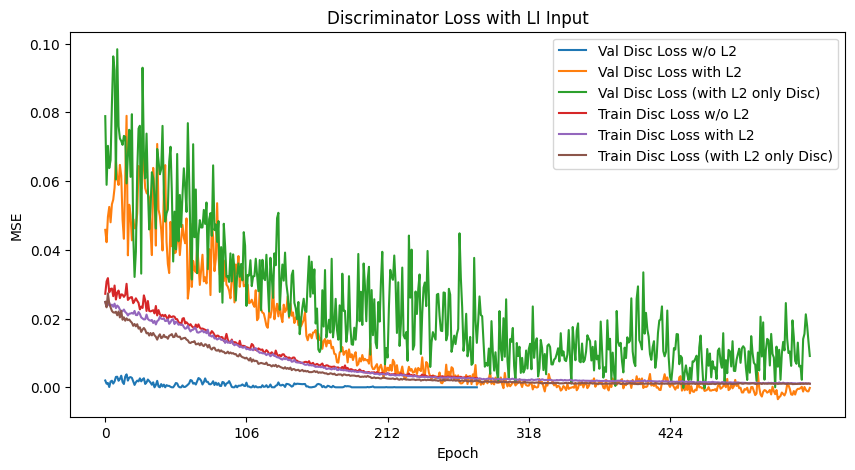

<Figure size 640x480 with 0 Axes>

In [25]:
toplot_1 = data27_linear['val_gan_disc_loss'].flatten().tolist()
toplot_2 = data28_linear['val_gan_disc_loss'].flatten().tolist()
toplot_3 = data29_linear['val_gan_disc_loss'].flatten().tolist()
toplot_1_ = data27_linear['train_disc_loss'].flatten().tolist()
toplot_2_ = data28_linear['train_disc_loss'].flatten().tolist()
toplot_3_ = data29_linear['train_disc_loss'].flatten().tolist()
plotfig.figLoss(line_list=[(toplot_1[70:], 'Val Disc Loss w/o L2'), (toplot_2[70:], 'Val Disc Loss with L2'),
                        (toplot_3[70:], 'Val Disc Loss (with L2 only Disc)'), (toplot_1_[70:], 'Train Disc Loss w/o L2'), (toplot_2_[70:], 'Train Disc Loss with L2'),
                        (toplot_3_[70:], 'Train Disc Loss (with L2 only Disc)')], xlabel='Epoch', ylabel='MSE',
                        title='Discriminator Loss with LI Input', fig_show=True, fig_name='Loss')

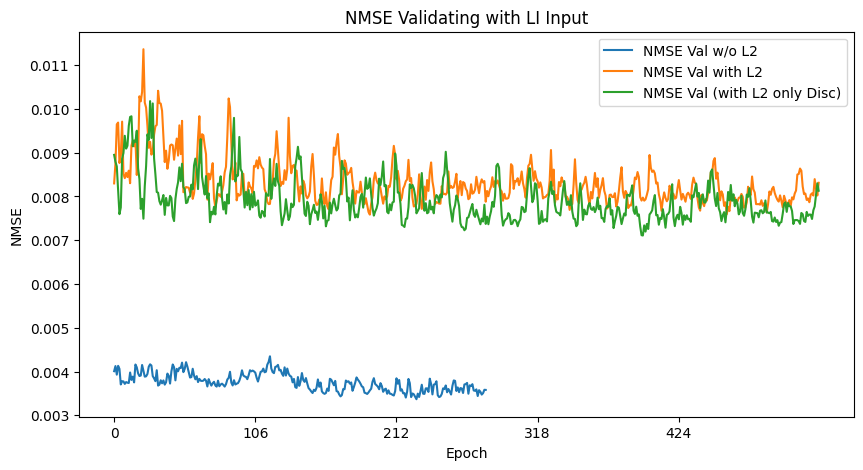

<Figure size 640x480 with 0 Axes>

In [27]:
toplot_1 = data27_linear['nmse_val_source'].flatten().tolist()
toplot_2 = data28_linear['nmse_val_source'].flatten().tolist()
toplot_3 = data29_linear['nmse_val_source'].flatten().tolist()
plotfig.figLoss(line_list=[(toplot_1[70:], 'NMSE Val w/o L2'), (toplot_2[70:], 'NMSE Val with L2'),
                        (toplot_3[70:], 'NMSE Val (with L2 only Disc)')], xlabel='Epoch', ylabel='NMSE',
                        title='NMSE Validating with LI Input', fig_show=True, fig_name='Loss')

#

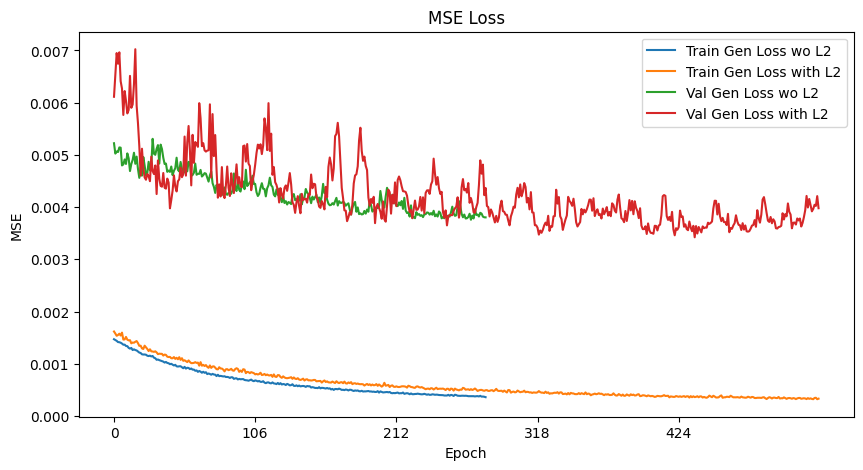

<Figure size 640x480 with 0 Axes>

In [ ]:
toplot_1 = data27_practical['train_est_loss'].flatten().tolist()
toplot_2 = data28_practical['train_est_loss'].flatten().tolist()
toplot_3 = data27_practical['val_est_loss'].flatten().tolist()
toplot_4 = data28_practical['val_est_loss'].flatten().tolist()
plotfig.figLoss(line_list=[(toplot_1[70:], 'Train Gen Loss wo L2'), (toplot_2[70:], 'Train Gen Loss with L2'),
                        (toplot_3[70:], 'Val Gen Loss wo L2'), (toplot_4[70:], 'Val Gen Loss with L2')], xlabel='Epoch', ylabel='MSE',
                        title='MSE Loss', fig_show=True, fig_name='Loss')

In [21]:
toplot_1 = data['train_disc_loss'].flatten().tolist()
toplot_2 = data['val_gan_disc_loss'].flatten().tolist()
plotfig.figLoss(line_list=[(toplot_1[70:], 'Train Disc Loss'), (toplot_2[70:], 'Val Disc Loss')], xlabel='Epoch', ylabel='BCE',
                        title='Val GAN Disc Loss', fig_show=True, fig_name='Loss')

NameError: name 'data' is not defined

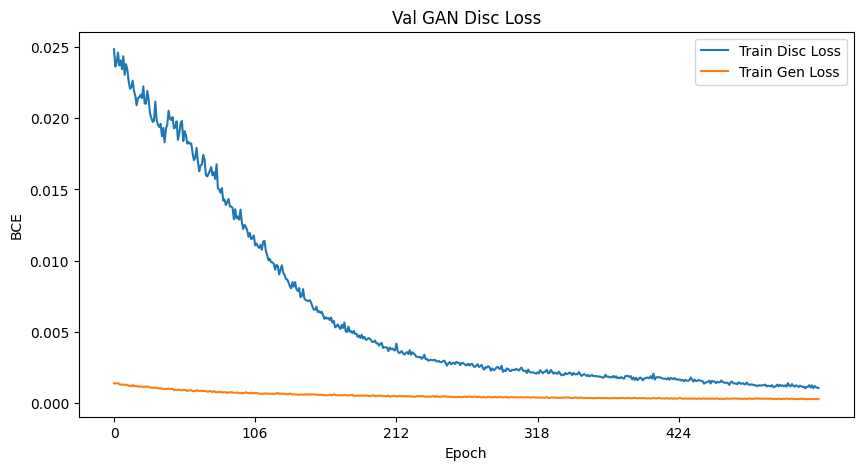

<Figure size 640x480 with 0 Axes>

In [ ]:
toplot_1 = data['train_disc_loss'].flatten().tolist()
toplot_2 = data['train_est_loss'].flatten().tolist()
plotfig.figLoss(line_list=[(toplot_1[70:], 'Train Disc Loss'), (toplot_2[70:], 'Train Gen Loss')], xlabel='Epoch', ylabel='BCE',
                        title='Val GAN Disc Loss', fig_show=True, fig_name='Loss')

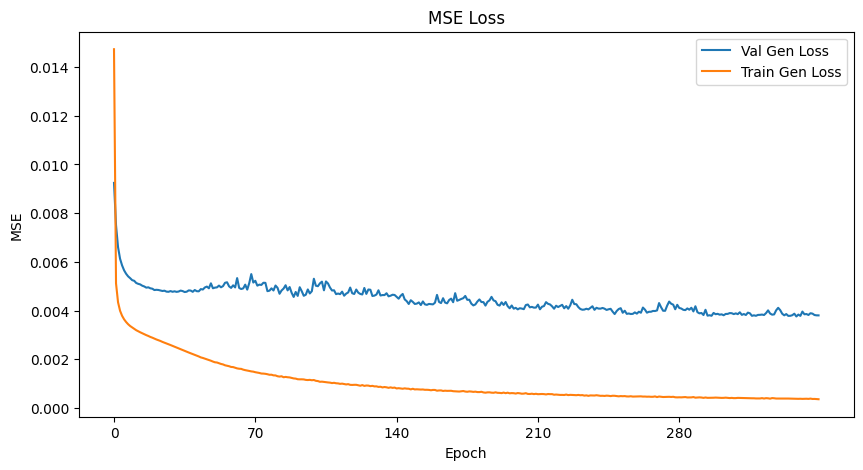

<Figure size 640x480 with 0 Axes>

In [ ]:
toplot_1 = data['val_est_loss'].flatten().tolist()
toplot_2 = data['train_est_loss'].flatten().tolist()
plotfig.figLoss(line_list=[(toplot_1, 'Val Gen Loss'), (toplot_2, 'Train Gen Loss')], xlabel='Epoch', ylabel='MSE',
                        title='MSE Loss', fig_show=True, fig_name='Loss')
            